In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cais-x-t1-2021/submission.csv
/kaggle/input/cais-x-t1-2021/test.csv
/kaggle/input/cais-x-t1-2021/train.csv
/kaggle/input/us-counties-covid-data/us counties cais x data.csv


In [2]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.linear_model import LinearRegression        
from sklearn import preprocessing
from sklearn import utils
#import libaries to transform our features 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')
#modules for hyperparameter tuning
from scipy.stats import randint
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier



In [3]:
# Reading in the data
TRAIN_DATA=(r"../input/cais-x-t1-2021/train.csv")
TEST_DATA=(r"../input/cais-x-t1-2021/test.csv")

#Creating DataFrame
df=pd.read_csv(TRAIN_DATA)
test_df=pd.read_csv(TEST_DATA)

In [4]:
#visualizing train data
df.sample(6)

,Id,# Confirmed_Cases,# Deaths,# Recovered,# Tested,Date,Lat,Long,Population,Province,Testing_Info
2097,2097,0,NaN,0.0,NaN,2020-05-19,NaN,NaN,NaN,Repatriated,NaN
580,580,1,0.0,0.0,1.0,2020-03-17,46.5653,-66.4619,780890.0,New Brunswick,NaN
2333,2333,31,0.0,9.0,2147.0,2020-07-13,52.9399,-106.4509,1181987.0,Saskatchewan,NaN
1457,1457,0,NaN,0.0,NaN,2020-02-15,51.2538,-85.3232,14745040.0,Ontario,NaN
830,830,0,0.0,0.0,79.0,2020-05-24,53.1355,-57.6604,520437.0,NL,NaN
225,225,66,0.0,3.0,2822.0,2020-03-26,53.7267,-127.6476,5120184.0,BC,NaN


In [5]:
test_df.sample(6)

,ForcastId,# Tested,Date,Lat,Long,Population,Province,Testing_Info
715,715,2372.0,2020-09-26,52.9399,-106.4509,1181987.0,Saskatchewan,NaN
782,782,24.0,2020-10-02,64.2823,-135.0000,41293.0,Yukon,NaN
474,474,55.0,2020-09-29,64.8255,-124.8457,44982.0,NWT,NaN
216,216,380.0,2020-09-15,46.5653,-66.4619,780890.0,New Brunswick,NaN
21,21,9553.0,2020-09-03,53.9333,-116.5765,4428247.0,Alberta,NaN
785,785,36.0,2020-10-05,64.2823,-135.0000,41293.0,Yukon,NaN


In [6]:
#SHowing data types of each column
df.dtypes

Id                     int64
# Confirmed_Cases      int64
# Deaths             float64
# Recovered          float64
# Tested             float64
Date                  object
Lat                  float64
Long                 float64
Population           float64
Province              object
Testing_Info          object
dtype: object

In [7]:
#change date_report column from object data types to date datatypes 
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
test_df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [8]:
df.dtypes

Id                            int64
# Confirmed_Cases             int64
# Deaths                    float64
# Recovered                 float64
# Tested                    float64
Date                 datetime64[ns]
Lat                         float64
Long                        float64
Population                  float64
Province                     object
Testing_Info                 object
dtype: object

Text(0, 0.5, 'Number of Cases')

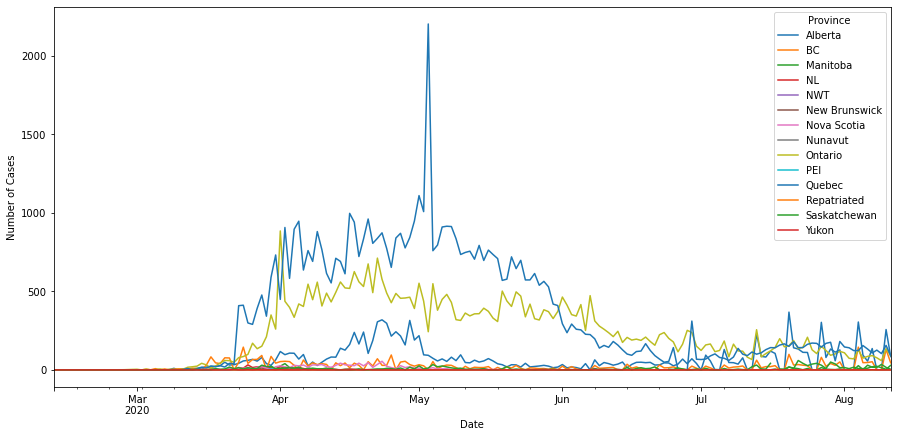

In [9]:
import matplotlib.pyplot as plt

#Graph of number of cases
#create the graph and make it size 15 x 7
fig, ax = plt.subplots(figsize=(15,7))
# group based on the Date 
# further group based on the Province
# find the Number of Confirmed Cases for that particular grouping 
df.groupby(['Date','Province']).mean()['# Confirmed_Cases'].unstack().plot(ax=ax)
#set x-axis label
ax.set_xlabel('Date')
#set y-axis label
ax.set_ylabel('Number of Cases')

Text(0, 0.5, 'Number of Deaths')

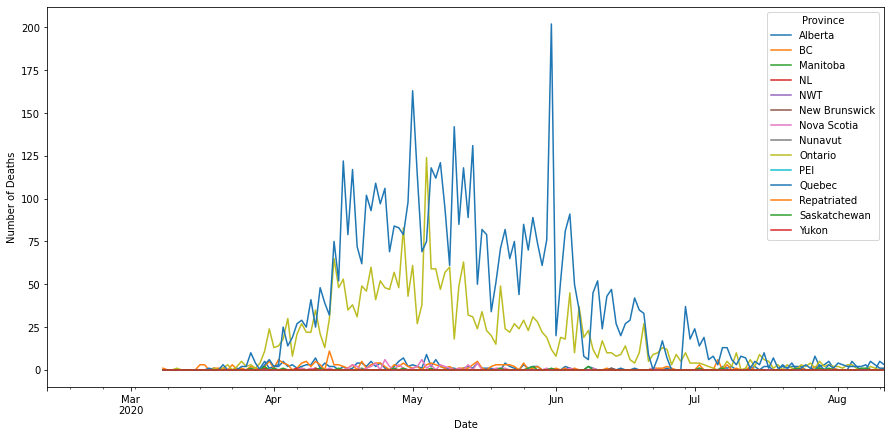

In [10]:
#number of covid deaths
fig, ax = plt.subplots(figsize=(15,7))
# First grouping based on the Date 
# For each Date we further group based on the Province
# With this grouped information, we'll find the Number of Deaths for that particular grouping 
df.groupby(['Date','Province']).mean()['# Deaths'].unstack().plot(ax=ax)
#set x-axis label
ax.set_xlabel('Date')
#set y-axis label
ax.set_ylabel('Number of Deaths')

Text(0, 0.5, 'Number of Cases(weekly)')

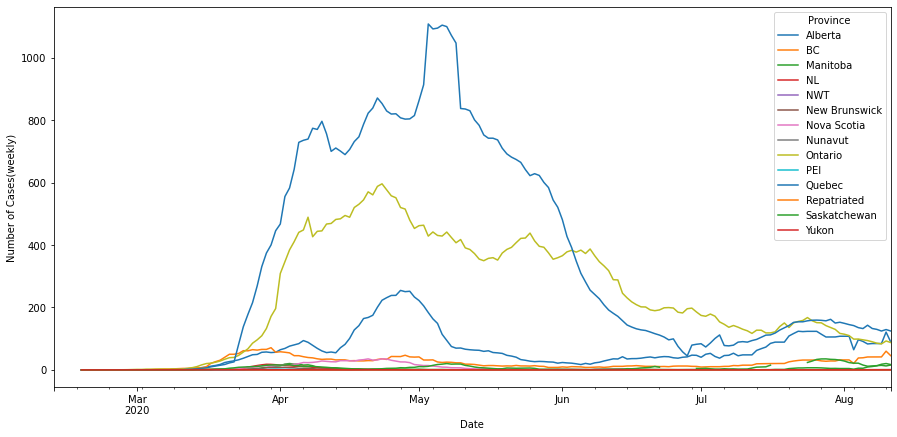

In [11]:
#To make the data a little smoother, lets visualize the data by weekly periods 
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['Date','Province']).mean()['# Confirmed_Cases'].unstack().rolling(7).mean().plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cases(weekly)')

Text(0, 0.5, 'Number of Deaths(Weekly)')

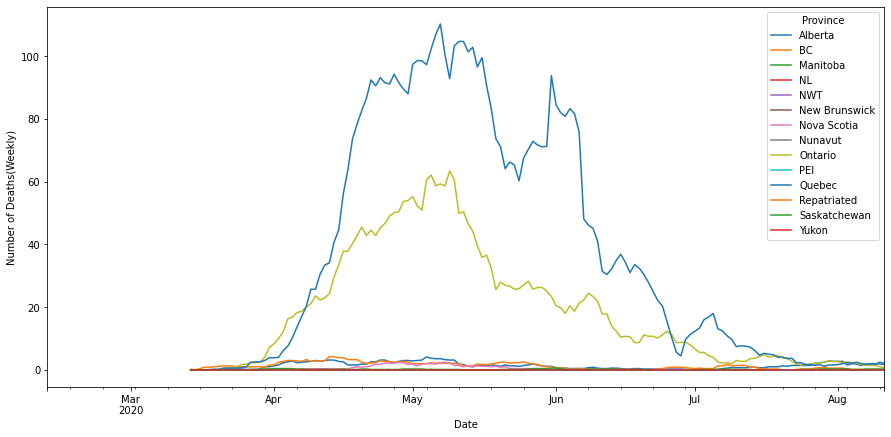

In [12]:
#weekly deat
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['Date','Province']).mean()['# Deaths'].unstack().rolling(7).mean().plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Deaths(Weekly)')

In [13]:
#Handling null values
df.head()
#Replace all null(NaN) values with 0
df=df.fillna(0)
test_df = test_df.fillna(0)

# One Hot Encoding
df = pd.get_dummies(df)

df.head()

,Id,# Confirmed_Cases,# Deaths,# Recovered,# Tested,Date,Lat,Long,Population,Province_Alberta,...,Province_Nova Scotia,Province_Nunavut,Province_Ontario,Province_PEI,Province_Quebec,Province_Repatriated,Province_Saskatchewan,Province_Yukon,Testing_Info_0,Testing_Info_Change in reported testing definition.
0,0,0,0.0,0.0,0.0,2020-02-12,53.9333,-116.5765,4428247.0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0.0,0.0,0.0,2020-02-13,53.9333,-116.5765,4428247.0,1,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0.0,0.0,0.0,2020-02-14,53.9333,-116.5765,4428247.0,1,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0.0,0.0,0.0,2020-02-15,53.9333,-116.5765,4428247.0,1,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0.0,0.0,0.0,2020-02-16,53.9333,-116.5765,4428247.0,1,...,0,0,0,0,0,0,0,0,1,0


In [14]:
#use the day of year that a specific date is rather than the date itself. We're able to do this since the data is all within the same year.This is because we want to mske the date attribute similar to the rest of the data
from datetime import datetime
dayofyear = datetime.now().timetuple().tm_yday
df['Day'] = df['Date'].apply(lambda x: x.dayofyear)
test_df['Day'] = df['Date'].apply(lambda x: x.dayofyear)
df['Day']

0        43
1        44
2        45
3        46
4        47
       ... 
2539    220
2540    221
2541    222
2542    223
2543    224
Name: Day, Length: 2544, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import decomposition, datasets
# Splitting the data. 

X = df[['Id','Day', 'Population', '# Tested', 'Long','Lat']]
y = df[['Id','# Deaths','# Confirmed_Cases', '# Recovered']]


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.31132, random_state = 0)

#Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


#Random Forest Regressor
rf = RandomForestRegressor(random_state = 0)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [16]:
#Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.6s finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=2, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [18]:
#Predicting.........
y_pred = rf_random.predict(X_test)
y_pred

array([[1.63764261e+03, 1.32449413e-01, 3.05931595e+00, 2.33949536e+00],
       [4.10833569e+02, 1.05612686e-01, 4.35900320e+00, 5.50621867e+00],
       [1.33452203e+03, 2.52222222e-02, 1.42540111e+00, 4.59032221e-01],
       ...,
       [2.14451359e+03, 5.15463918e-04, 2.77076862e-01, 1.88729643e-01],
       [6.86523332e+01, 2.06763412e+00, 1.51441368e+02, 9.93020017e+01],
       [2.07888950e+03, 5.15463918e-04, 3.19257578e-01, 4.12174599e-01]])

In [19]:
#Graphing prediction results
y

,Id,# Deaths,# Confirmed_Cases,# Recovered
0,0,0.0,0,0.0
1,1,0.0,0,0.0
2,2,0.0,0,0.0
3,3,0.0,0,0.0
4,4,0.0,0,0.0
...,...,...,...,...
2539,2539,0.0,1,0.0
2540,2540,0.0,0,0.0
2541,2541,0.0,0,0.0
2542,2542,0.0,0,0.0


In [20]:
X

,Id,Day,Population,# Tested,Long,Lat
0,0,43,4428247.0,0.0,-116.5765,53.9333
1,1,44,4428247.0,0.0,-116.5765,53.9333
2,2,45,4428247.0,0.0,-116.5765,53.9333
3,3,46,4428247.0,0.0,-116.5765,53.9333
4,4,47,4428247.0,0.0,-116.5765,53.9333
...,...,...,...,...,...,...
2539,2539,220,41293.0,44.0,-135.0000,64.2823
2540,2540,221,41293.0,0.0,-135.0000,64.2823
2541,2541,222,41293.0,0.0,-135.0000,64.2823
2542,2542,223,41293.0,125.0,-135.0000,64.2823


In [21]:
#Making dataset
dataset = pd.DataFrame({'ForcastId': y_pred[:, 0], '# Deaths': y_pred[:, 1], '# Confirmed_Cases': y_pred[:, 2], '# Recovered': y_pred[:, 3]})
#Make the index column called 'ForcastId'
dataset['ForcastId'] = dataset.index
print(dataset)

     ForcastId   # Deaths  # Confirmed_Cases  # Recovered
0            0   0.132449           3.059316     2.339495
1            1   0.105613           4.359003     5.506219
2            2   0.025222           1.425401     0.459032
3            3   0.015823           1.384861     1.036727
4            4   0.000515           0.291984     0.383473
..         ...        ...                ...          ...
787        787  11.220510         193.177717   152.699391
788        788   0.103980           6.782435     8.207178
789        789   0.000515           0.277077     0.188730
790        790   2.067634         151.441368    99.302002
791        791   0.000515           0.319258     0.412175

[792 rows x 4 columns]


In [22]:
#Turn the dataframe into a csv file that contains the predictions 
dataset.to_csv('predictions.csv',index = False)

In [23]:
#Accuracy
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    a = np.mean(errors)
    print(a)



In [24]:
evaluate(rf_random, X_test, y_test)

Id                   154.084577
# Deaths               1.983258
# Confirmed_Cases     19.654731
# Recovered           47.316798
dtype: float64
